In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST', one_hot=True)

print('Statistics:')
print('- Training set\t\t{}'.format(len(data.train.labels)))
print('- Test set\t\t{}'.format(len(data.test.labels)))
print('- Validation set\t{}'.format(len(data.validation.labels)))

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Statistics:
- Training set		55000
- Test set		10000
- Validation set	5000


In [3]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])
print(data.test.labels[0:5, :])
print(data.test.cls[0:5])

[[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]
[7 2 1 0 4]


In [11]:
# Some constants for the image size
img_size = 28
img_shape = (img_size, img_size)
img_size_flat = img_size * img_size

# dataset constants
num_classes = 10

# model constants
lmbda = 0.01
neta = 0.5

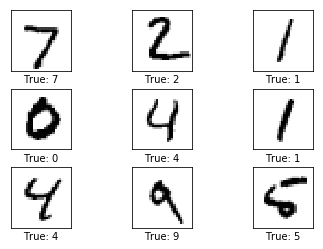

In [5]:
def plot_images(images, cls_true, cls_pred=None):
    """Shameless p&c to display images"""
    
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        
        if cls_pred:
            x_label = 'True: {} Pred: {}'.format(cls_true[i], cls_pred[i])
        else:
            x_label = 'True: {}'.format(cls_true[i])
        
        ax.set_xlabel(x_label)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()
    
plot_images(data.test.images[0:9], data.test.cls[:9])

In [39]:
# now the fun begins

# inputs
x = tf.placeholder(tf.float32, [None, img_size_flat])
y_true = tf.placeholder(tf.float32, [None, num_classes])
y_true_cls = tf.placeholder(tf.int64, [None])

# model variables. Change this for simmetry break
# weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))
weights = tf.Variable(tf.random_uniform([img_size_flat, num_classes], minval=-1.0, maxval=1.0))
biases = tf.Variable(tf.zeros([num_classes]))

# the model -- Logistic regression
logits = tf.matmul(x, weights) + biases
y_pred = tf.nn.softmax(logits)
y_pred_cls = tf.arg_max(y_pred, dimension=1)

# cost function part
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_true)
cost = tf.reduce_mean(cross_entropy) + tf.nn.l2_loss(weights) * lmbda

# finally, optimizing
optimizer = tf.train.GradientDescentOptimizer(learning_rate=neta).minimize(cost)

# measuring performance to monitor model convergence
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [51]:
# Running the model
session = tf.Session()
session.run(tf.global_variables_initializer())

# constants go in here
batch_size = 100
def optimize(num_iterations):
    for i in range(num_iterations):
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        session.run(optimizer, {
            x: x_batch,
            y_true: y_true_batch
        })
        
def print_accuracy():
    acc = session.run(accuracy, {
        x: data.test.images,
        y_true: data.test.labels,
        y_true_cls: data.test.cls
    })
    print('Acc on test-set: {}'.format(acc))
    
def print_confusion_matrix():
    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the predicted classifications for the test-set.
    cls_pred = session.run(y_pred_cls, feed_dict={
                    x: data.test.images,
                    y_true: data.test.labels,
                    y_true_cls: data.test.cls})

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.viridis)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

In [8]:
# initial performance
print_accuracy()

# after 1 loop
optimize(num_iterations=1)
print_accuracy()

# 9 more to go
optimize(num_iterations=9)
print_accuracy()

# 990 more to go
optimize(num_iterations=990)
print_accuracy()

Acc on test-set: 0.09799999743700027
Acc on test-set: 0.35659998655319214
Acc on test-set: 0.7785000205039978
Acc on test-set: 0.9154999852180481


[[ 955    0    4    4    0    8    4    1    3    1]
 [   0 1093    5    4    0    2    4    1   26    0]
 [  21   10  876   14   25    4   18   16   41    7]
 [  10    1   19  854    6   51    5   16   34   14]
 [   5    3    1    1  913    1    9    2   10   37]
 [  18    5    9   47   23  696   12    7   62   13]
 [  32    3    5    3   31   23  850    2    8    1]
 [   5   17   38    4   17    2    0  873    8   64]
 [  15    7    8   14   19   29   16    9  834   23]
 [  16    8    2   11   81    5    1   14   14  857]]


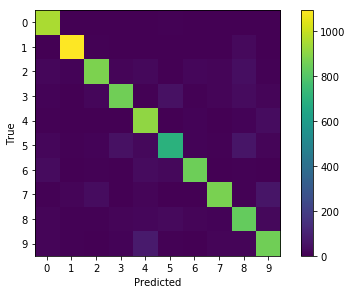

In [53]:
print_confusion_matrix()
plt.show()

In [50]:
session.close()
session = tf.Session()

In [52]:
# some experimentation
session.run(tf.global_variables_initializer())
optimize(num_iterations=200)
print_accuracy()

Acc on test-set: 0.8801000118255615
